In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import networkx as nx

from datasets import (load_AlphaFold_RoseTTAFold, 
                      load_Y2H_union_25,
                      load_I3D_exp_24,
                      load_lit_bm_24)
from plotting import (COLOR_ALPHAFOLD_ROSETTAFOLD, 
                      COLOR_Y2H,
                      COLOR_I3D,
                      COLOR_LIT)
from utils import format_network

In [2]:
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
afrf_table = load_AlphaFold_RoseTTAFold(remove_homodimers=True, 
                                        restrict_to_high_confidence=True)
y2h_union_table = load_Y2H_union_25(remove_homodimers=True)
lit_table = load_lit_bm_24(remove_homodimers=True)
i3d_table = load_I3D_exp_24(remove_homodimers=True)

afrf = format_network(afrf_table, 'nx', id_type='orf_name', suffixes=['_a', '_b'])
y2h_union = format_network(y2h_union_table, 'nx', id_type='orf_name', suffixes=['_a', '_b'])
i3d = format_network(i3d_table, 'nx', id_type='orf_name', suffixes=['_a', '_b'])
lit = format_network(lit_table, 'nx', id_type='orf_name', suffixes=['_a', '_b'])

NOTE: dropping 6 pairs with missing ORF names


In [4]:
def pct_nodes_in_largest_connected_component(nw):
    return max(len(c) for c in nx.connected_components(nw)) / len(nw.nodes) * 100

n_samples = 1000
fracs = np.arange(0.05, 1, 0.05)
sampled_pct_in_lcc = []
sampled_avrg_k = []
for table in [y2h_union_table, lit_table, i3d_table, afrf_table]:
    sampled_pct_in_lcc.append({f: [] for f in fracs})
    sampled_avrg_k.append({f: [] for f in fracs})
    for f in fracs:
        for __ in range(n_samples):
            rnd = table.sample(frac=f, replace=False)
            rnd = format_network(rnd, 'nx', id_type='orf_name', suffixes=['_a', '_b'])
            sampled_pct_in_lcc[-1][f].append(pct_nodes_in_largest_connected_component(rnd))
            sampled_avrg_k[-1][f].append(len(rnd.edges) / len(rnd.nodes) * 2)

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_8361/291315459.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])


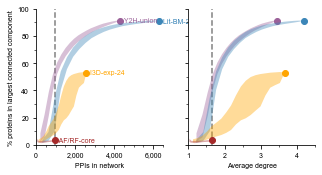

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True)
ax, ax2 = axs
fig.set_size_inches(w=5, h=2.5)

# NOTE: this order has to match above in samples
nws = [(y2h_union, COLOR_Y2H, 'Y2H-union'),
       (lit, COLOR_LIT, 'Lit-BM-24'),
       (i3d, COLOR_I3D, 'I3D-exp-24'),
       (afrf, COLOR_ALPHAFOLD_ROSETTAFOLD, 'AF/RF-core')]

for (nw, color, name), rnd_samples in zip(nws, sampled_pct_in_lcc):
        pct = pct_nodes_in_largest_connected_component(nw)
        ax.scatter(len(nw.edges), pct, color=color)
        ax.text(x=len(nw.edges), y=pct, s='  ' + name, color=color, ha='left', va='center')
        ax.fill_between(x=[f * len(nw.edges) for f in fracs] + [len(nw.edges)],
                y1=[np.quantile(x, 0.05) for x in rnd_samples.values()] + [pct],
                        y2=[np.quantile(x, 0.95) for x in rnd_samples.values()] + [pct],
                color=color,
                alpha=0.4,
                linewidths=[0, 0])

ax.axvline(x=len(afrf.edges), color='grey', linestyle='--', zorder=-1)
ax.set_ylim(0, 100)
ax.set_xlim(0, 6500)
ax.set_ylabel('% proteins in largest connected component')
ax.set_xlabel('PPIs in network')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks(range(0, 100, 10), minor=True)
ax.set_xticks(range(0, 6501, 500), minor=True)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])


# change each x point to average degree
for (nw, color, name), rnd_samples_pct, rnd_samples_avrg_k in zip(nws, sampled_pct_in_lcc, sampled_avrg_k):
        pct = pct_nodes_in_largest_connected_component(nw)
        avrg_k = len(nw.edges) / len(nw.nodes) * 2
        ax2.scatter(avrg_k, pct, color=color)
        ax2.fill_between(x=[np.mean(x) for x in rnd_samples_avrg_k.values()] + [avrg_k],
                        y1=[np.quantile(x, 0.05) for x in rnd_samples_pct.values()] + [pct],
                        y2=[np.quantile(x, 0.95) for x in rnd_samples_pct.values()] + [pct],
                color=color,
                alpha=0.4,
                linewidths=[0, 0])
# NOTE: can't go below an average degree of 1 with the sampling method of 
# picking pairs (since you have no unconnected nodes)
ax2.set_xlim(1, 4.5)
ax2.set_xticks(range(1, 5))
ax2.set_xticks(np.arange(1, 5, 0.5), minor=True)
ax2.set_xlabel('Average degree')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.axvline(x=len(afrf.edges) / len(afrf.nodes) * 2, color='grey', linestyle='--', zorder=-1)

plt.savefig('../figures/network_fragmentation.pdf',
            bbox_inches='tight')

In [6]:
def mean_degree(nw):
    return len(nw.edges) / len(nw.nodes) * 2

def Molloy_Reed_kappa(nw):
    return np.mean([k**2 for _node_name, k in nw.degree]) / mean_degree(afrf)



for name, nw in [('Humphreys', afrf), ('I3D-exp-20', i3d), ('Y2H-union-25', y2h_union), ('Lit-BM-20', lit)]:
    print('{} - N = {} nodes, <k> = {:.1f} average degree, highest degree node = {}, r = {:.2f} degree correlation, Molloy Reed kappa = {:.1f}'.format(name,
                                                                                                 len(nw.nodes), 
                                                                                                 len(nw.edges) / len(nw.nodes) * 2,
                                                                                                 max(k for _name, k in nw.degree),
                                                                                                 nx.degree_pearson_correlation_coefficient(nw),
                                                                                                 Molloy_Reed_kappa(nw)
                                                                                                 ))

Humphreys - N = 1177 nodes, <k> = 1.6 average degree, highest degree node = 8, r = 0.38 degree correlation, Molloy Reed kappa = 2.2
I3D-exp-20 - N = 1408 nodes, <k> = 3.7 average degree, highest degree node = 31, r = 0.20 degree correlation, Molloy Reed kappa = 13.7
Y2H-union-25 - N = 2505 nodes, <k> = 3.4 average degree, highest degree node = 134, r = -0.07 degree correlation, Molloy Reed kappa = 28.7
Lit-BM-20 - N = 3011 nodes, <k> = 4.2 average degree, highest degree node = 92, r = -0.10 degree correlation, Molloy Reed kappa = 27.9
